In [81]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [82]:
class RobotAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def step(self):
        x, y = self.pos
        if self.model.dirty_cells[x][y]:  
            self.model.dirty_cells[x][y] = False 
        else:
            neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            if neighbors:  
                next_move = self.random.choice(neighbors)
                if self.model.grid.is_cell_empty(next_move):
                    self.model.grid.move_agent(self, next_move)

In [83]:
def get_grid(model):
    return model.dirty_cells

In [84]:
class RoomModel(Model):
    def __init__(self, width, height, num_agents, dirty_cells_percentage):
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        total_cells = width * height
        num_dirty_cells = int(total_cells * dirty_cells_percentage)
        dirty_indices = np.random.choice(range(total_cells), num_dirty_cells, replace=False)
        self.dirty_cells = np.zeros((width, height), dtype=bool)
        for index in dirty_indices:
            x, y = divmod(index, height)
            self.dirty_cells[x, y] = True

        for i in range(num_agents):
            agent = RobotAgent(i, self)
            self.grid.place_agent(agent, (1, 1))
            self.schedule.add(agent)
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [85]:
WIDTH = 100
HEIGHT = 100
NUM_AGENTS = 2
DIRTY_CELLS = .90

MAX_STEPS = 100

model = RoomModel(WIDTH, HEIGHT, NUM_AGENTS, DIRTY_CELLS)
for i in range(MAX_STEPS):
    model.step()
    

In [86]:
all_grid = model.datacollector.get_model_vars_dataframe()

/var/folders/f0/_1kmynrd62zdz552kgfzq_9w0000gn/T/ipykernel_1428/1805408665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)


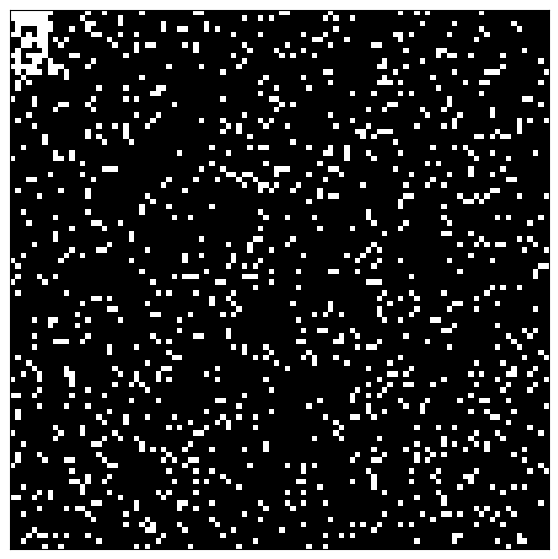

In [87]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)